<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Logistic_/softmax_regression_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Softmax Regression**

Imports

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

Preparing the dataset

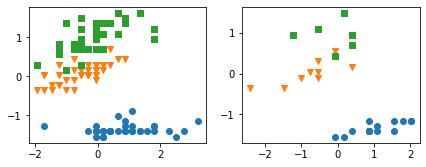

In [62]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss20/master/L07-logistic/code/data/iris.data',
                 index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']

d = {'Iris-versicolor': 1,
     'Iris-virginica': 2,
     'Iris-setosa': 0,
}

df['y'] = df['y'].map(d)

X = torch.tensor(df[['x2', 'x4']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# shuffle and train/test split

shuffled_idx = torch.randperm(X.size(0), dtype=torch.long)

X, y = X[shuffled_idx], y[shuffled_idx]

percent80 = int(X.size(0) * 0.8)

X_train, X_test = X[shuffled_idx[:percent80]], X[shuffled_idx[percent80:]]
y_train, y_test = y[shuffled_idx[:percent80]], y[shuffled_idx[percent80:]]

# Normalize (mean zero, unit variance)
mu, sigma = torch.mean(X_train, dim=0), torch.std(X_train, dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1])
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], marker='v')
ax[0].scatter(X_train[y_train==2, 0], X_train[y_train==2, 1], marker='s')
ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1])
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], marker='v')
ax[1].scatter(X_test[y_test==2, 0], X_test[y_test==2, 1], marker='s')
plt.show()

## Low level implementation with manual gradients

In [63]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [71]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    y_cpu = y.to(torch.device('cpu'))
    y_onehot.scatter_(1, y_cpu.view(-1, 1).long(), 1).float()
    return y_onehot.to(DEVICE)

def softmax(z):
    return (torch.exp(z.t()) / torch.sum(torch.exp(z), dim=1)).t()

def cross_entropy(softmax, y_target):
    return -torch.sum(torch.log(softmax) * (y_target), dim=1)

In [75]:
def custon_where(cond, x_1, x_2):
    return (cond * x_1) + ((1 - cond) * x_2)

class SoftmaxRegression1():
    def __init__(self, num_features, num_classes):
        self.num_features = num_features
        self.num_classes = num_classes
        self.weights = torch.zeros(num_classes, num_features,
                                   dtype=torch.float32, device=DEVICE)
        self.bias = torch.zeros(num_classes, dtype=torch.float32, device=DEVICE)

    def forward(self, x):
        logits = torch.add(torch.mm(x, self.weights.t()), self.bias)
        probas = softmax(logits)
        return logits, probas

    def backward(self, x, y, probas):
        grad_loss_out = y - probas # shape 120 X 3 
        grad_loss_w = -torch.mm(x.t(), grad_loss_out).t()
        grad_loss_b = -torch.sum(grad_loss_out)
        return grad_loss_w, grad_loss_b

    def predict_labels(self, x):
        logits, probas = self.forward(x)
        labels = torch.argmax(probas, dim=1)
        return labels
    
    def evaluate (self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy

    def train(self, x, y, num_epochs, learning_rate=0.01):
        epoch_cost = []
        for e in range(num_epochs):

            y_onehot = to_onehot(y, num_classes=self.num_classes)

            ## Compute outputs 
            logits, probas = self.forward(x)

            # compute gradients
            grad_w, grad_b = self.backward(x, y_onehot, probas)

            ## Update weights
            self.weights -= grad_w * learning_rate / y.size(0)
            self.bias -= grad_b * learning_rate / y.size(0)

            ### Logging 
            logits, probas = self.forward(x)
            cost = torch.mean(cross_entropy(probas, y_onehot))
            print(f"Epoch: {e+1:03d}", end="")
            print(f"    | Train Acc: {self.evaluate(x, y):.3f}%", end="")
            print(f"    | Cost: {cost:.5f}")
            epoch_cost.append(cost)
        return epoch_cost


In [76]:
X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)

model1 = SoftmaxRegression1(X_train.size(1), 3)
epoch_cost = model1.train(X_train, y_train,
                          num_epochs=50,
                          learning_rate=0.1)

print("\nModel Parameters")
print(f"    Weights: {model1.weights}")
print(f"    Bias: {model1.bias}")

Epoch: 001    | Train Acc: 0.833%    | Cost: 1.05976
Epoch: 002    | Train Acc: 0.833%    | Cost: 1.02392
Epoch: 003    | Train Acc: 0.833%    | Cost: 0.99087
Epoch: 004    | Train Acc: 0.833%    | Cost: 0.96040
Epoch: 005    | Train Acc: 0.833%    | Cost: 0.93229
Epoch: 006    | Train Acc: 0.833%    | Cost: 0.90636
Epoch: 007    | Train Acc: 0.825%    | Cost: 0.88240
Epoch: 008    | Train Acc: 0.825%    | Cost: 0.86023
Epoch: 009    | Train Acc: 0.825%    | Cost: 0.83971
Epoch: 010    | Train Acc: 0.825%    | Cost: 0.82066
Epoch: 011    | Train Acc: 0.825%    | Cost: 0.80296
Epoch: 012    | Train Acc: 0.825%    | Cost: 0.78648
Epoch: 013    | Train Acc: 0.825%    | Cost: 0.77110
Epoch: 014    | Train Acc: 0.825%    | Cost: 0.75674
Epoch: 015    | Train Acc: 0.825%    | Cost: 0.74330
Epoch: 016    | Train Acc: 0.825%    | Cost: 0.73069
Epoch: 017    | Train Acc: 0.825%    | Cost: 0.71885
Epoch: 018    | Train Acc: 0.825%    | Cost: 0.70771
Epoch: 019    | Train Acc: 0.825%    | Cost: 0

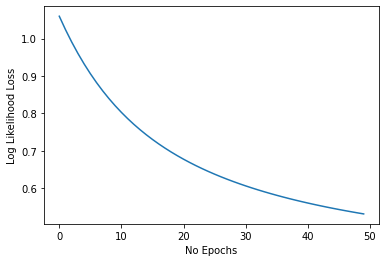

In [79]:
plt.plot(epoch_cost)
plt.ylabel('Log Likelihood Loss')
plt.xlabel('No Epochs')
plt.show()

In [80]:
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

test_acc = model1.evaluate(X_test, y_test)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 90.00%


In [81]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

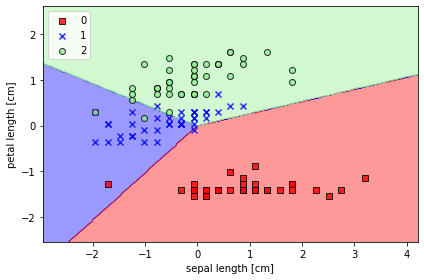

In [82]:
plot_decision_regions(X_train, y_train, classifier=model1)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## High-level implementation using nn.Module API

In [92]:
class SoftmaxRegression2(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression2, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        ## Initialize weights to zero since it is zero 
        ## in the manual method
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model2 = SoftmaxRegression2(num_features=2, num_classes=3).to(DEVICE)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [93]:
def comp_accuray(true_labels, pred_labels):
    accuracy = torch.sum(true_labels.view(-1).float() ==
                         pred_labels.float()).item() / true_labels.size(0)
    return accuracy

X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

num_epochs = 50
for e in range(num_epochs):

    # compute outputs 
    logits, probas = model2.forward(X_train)

    # Compute gradients
    cost = F.cross_entropy(logits, y_train.long())
    optimizer.zero_grad()
    cost.backward()

    ## update weights
    optimizer.step()

    ### logging 
    logits, probas = model2.forward(X_train)
    acc = comp_accuray(y_train, torch.argmax(probas, dim=1))
    print("Epoch: %03d" % (e + 1), end="")
    print(f"    |   Train ACC: {acc:.3f}", end="")
    print(f"    |   Cost: {F.cross_entropy(logits, y_train.long()):.3f}")

print("\nModel Parameters:")
print(f"    Weights: {model2.linear.weight}")
print(f"    Bias: {model2.linear.bias}")

Epoch: 001    |   Train ACC: 0.833    |   Cost: 1.059
Epoch: 002    |   Train ACC: 0.833    |   Cost: 1.023
Epoch: 003    |   Train ACC: 0.833    |   Cost: 0.990
Epoch: 004    |   Train ACC: 0.842    |   Cost: 0.959
Epoch: 005    |   Train ACC: 0.842    |   Cost: 0.931
Epoch: 006    |   Train ACC: 0.842    |   Cost: 0.905
Epoch: 007    |   Train ACC: 0.842    |   Cost: 0.880
Epoch: 008    |   Train ACC: 0.842    |   Cost: 0.858
Epoch: 009    |   Train ACC: 0.842    |   Cost: 0.837
Epoch: 010    |   Train ACC: 0.842    |   Cost: 0.818
Epoch: 011    |   Train ACC: 0.842    |   Cost: 0.800
Epoch: 012    |   Train ACC: 0.842    |   Cost: 0.783
Epoch: 013    |   Train ACC: 0.842    |   Cost: 0.767
Epoch: 014    |   Train ACC: 0.842    |   Cost: 0.753
Epoch: 015    |   Train ACC: 0.842    |   Cost: 0.739
Epoch: 016    |   Train ACC: 0.842    |   Cost: 0.726
Epoch: 017    |   Train ACC: 0.842    |   Cost: 0.714
Epoch: 018    |   Train ACC: 0.842    |   Cost: 0.702
Epoch: 019    |   Train ACC:

In [94]:
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

test_acc = model1.evaluate(X_test, y_test)
print("Test set accuracy: %.2f" % (test_acc*100))

Test set accuracy: 90.00


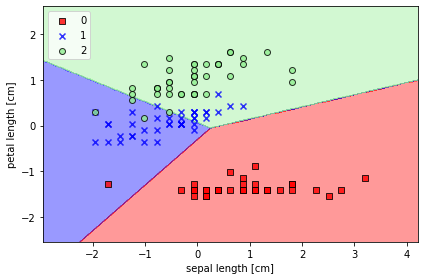

In [96]:
plot_decision_regions(X_train, y_train, classifier=model2)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()